In [1]:
%matplotlib qt5

In [2]:
import hyperspy.api as hs

In [13]:
s = hs.load("003_EELS-SI_1.7nm_2mmAp_TiO_Stack_Averaged denoised.dm3")
s

<EELSSpectrum, title: 003_EELS-SI_1.7nm_2mmAp_TiO_Stack_Averaged denoised, dimensions: (40, 236|1028)>

In [ ]:
s.plot()

In [ ]:
s.set_microscope_parameters(beam_energy=300, collection_angle=50, convergence_angle=40)
s.metadata

In [ ]:
# s.add_elements(('Ti', 'O'))

In [14]:
s = s.inav[1:-1, 1:-1]
s

<EELSSpectrum, title: 003_EELS-SI_1.7nm_2mmAp_TiO_Stack_Averaged denoised, dimensions: (38, 234|1028)>

In [ ]:
s.plot()

In [15]:
s.decomposition(normalize_poissonian_noise=True)

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=None
  centre=None


In [ ]:
s.plot_explained_variance_ratio()

In [16]:
s_denoised = s.get_decomposition_model(components=4)

In [ ]:
s_denoised.plot()

In [17]:
s.blind_source_separation(number_of_components=4)

[########################################] | 100% Completed | 101.86 ms


Blind source separation info:
  number_of_components=4
  algorithm=sklearn_fastica
  diff_order=1
  reverse_component_criterion=factors
  whiten_method=PCA
scikit-learn estimator:
FastICA(tol=1e-10, whiten=False)


/home/gt622/mambaforge/envs/hyperspy_env/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


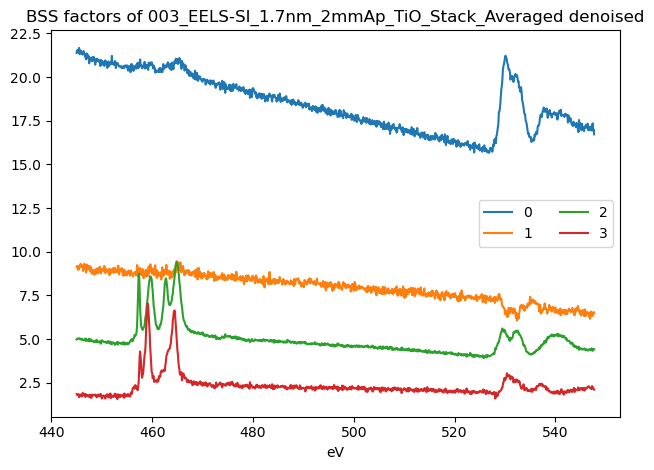

In [29]:
s.plot_bss_factors()

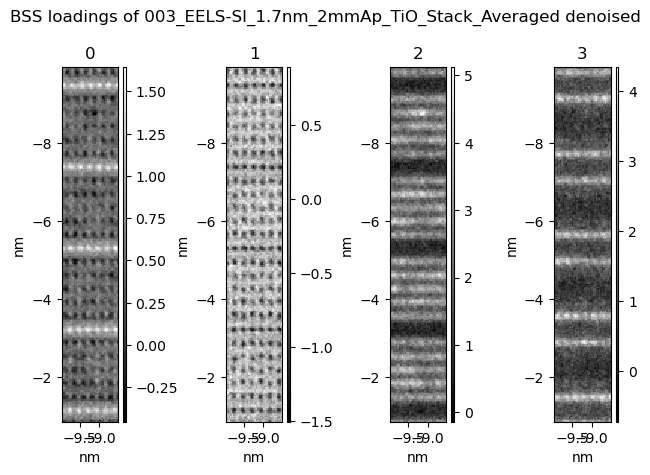

In [30]:
s.plot_bss_loadings(per_row=4)

In [18]:
s_denoised.remove_background()

/home/gt622/mambaforge/envs/hyperspy_env/lib/python3.11/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


In [19]:
Ti_peak = s_denoised.isig[455.:470.]
Ti_peak

<EELSSpectrum, title: 003_EELS-SI_1.7nm_2mmAp_TiO_Stack_Averaged denoised model from decomposition with 4 components, dimensions: (38, 234|150)>

In [9]:
Ti_peak.plot()

In [ ]:
roi = hs.roi.RectangularROI()
roi.add_widget(Ti_peak, axes=('x', 'y'))

In [ ]:
Ti_peak_cropped = Ti_peak.inav[roi]
Ti_peak_cropped

In [ ]:
Ti_peak_cropped.plot()

In [22]:
m = Ti_peak.create_model(auto_background=False)

In [23]:
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------

In [24]:
m.plot(plot_components=True)

In [25]:
g1 = hs.model.components1D.GaussianHF()
m.append(g1)
m.components.GaussianHF.name = "e_g"

In [26]:
m.fit_component(g1, signal_range=(458., 461.), only_current=False)

  0%|          | 0/8892 [00:00<?, ?it/s]

In [ ]:
# g1.plot()

In [27]:
g2 = hs.model.components1D.GaussianHF()
m.append(g2)
m.components.GaussianHF.name = "t_2g"

In [28]:
m.fit_component(g2, signal_range=(456., 458.), only_current=False)

  0%|          | 0/8892 [00:00<?, ?it/s]

In [31]:
m.set_signal_range(456.4, 461.)

In [32]:
m.multifit(iterpath="serpentine")

  0%|          | 0/8892 [00:00<?, ?it/s]

In [33]:
m.reset_signal_range()

In [34]:
eg_t2g_ratio = g1.height.as_signal() / g2.height.as_signal()

In [35]:
eg_t2g_ratio.plot()

In [36]:
g1.set_parameters_not_free()
g2.set_parameters_not_free()

In [37]:
g3 = hs.model.components1D.GaussianHF()
m.append(g3)
m.components.GaussianHF.name = "L_2"

In [42]:
m.fit_component(g3, only_current=False)

  0%|          | 0/8892 [00:00<?, ?it/s]

In [43]:
m.reset_signal_range()

In [44]:
g4 = hs.model.components1D.Gaussian()
m.append(g4)

In [45]:
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |                 e_g |                 e_g |          GaussianHF
   1 |                t_2g |                t_2g |          GaussianHF
   2 |                 L_2 |                 L_2 |          GaussianHF
   3 |            Gaussian |            Gaussian |            Gaussian

In [46]:
m.store(name='okay_fit')

In [47]:
m.fit_component(g4, only_current=False)

  0%|          | 0/8892 [00:00<?, ?it/s]

In [ ]:
m.set_signal_range()

In [50]:
m.store(name='okay_fit')

In [49]:
m.save("Ti_fit.hspy")

In [51]:
hs.plot.plot_images([m.components.e_g.fwhm.as_signal(), m.components.e_g.height.as_signal()],
                   label=["FWHM", "Height"],
                   axes_decor="off")

[<Axes: title={'center': 'FWHM'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>,
 <Axes: title={'center': 'Height'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>]